# Statystyka praktyczna w data science (Python)
# Rozdział 3. Eksperymenty statystyczne i testowanie istotności
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Importuje wymagane pakiety Pythona.

In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

DATA = Path('.').resolve().parents[1] / 'dane'

Definiuje ścieżki do zestawów danych. Jeżeli przechowujesz dane w innym katalogu, wprowadź poniżej stosowne zmiany.

In [2]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

# Test randomizacyjny

In [3]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

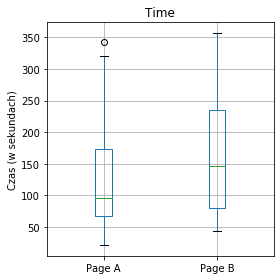

In [5]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Czas (w sekundach)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [6]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


Poniższy kod różni się od wersji stosowanej w R. Zamieniono miejscami zmienne idx_A i idx_B.

In [7]:
# Przykład testu permutacyjnego dla czasu przebywania na stronie
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-6.961904761904776


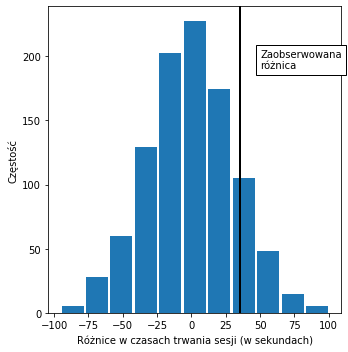

In [8]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Zaobserwowana\nróżnica', bbox={'facecolor':'white'})
ax.set_xlabel('Różnice w czasach trwania sesji (w sekundach)')
ax.set_ylabel('Częstość')

plt.tight_layout()
plt.show()

In [14]:
print(np.mean(perm_diffs > mean_b - mean_a))

TypeError: '>' not supported between instances of 'list' and 'float'

# Istotność statystyczna i p-wartości

Zaobserwowana różnica: 0.0368%


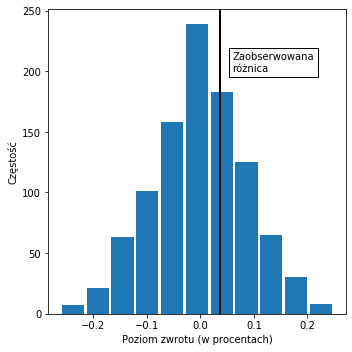

In [15]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Zaobserwowana różnica: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Zaobserwowana\nróżnica', bbox={'facecolor':'white'})
ax.set_xlabel('Poziom zwrotu (w procentach)')
ax.set_ylabel('Częstość')

plt.tight_layout()
plt.show()

## p-wartość
Jeżeli metoda `np.mean` zostanie użyta na liście wartości logicznych, zostanie obliczony odsetek wartości True znalezionych w tej liście (#True / #Całkowite).

In [16]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [17]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-wartość testu jednostronnego: {p_value / 2:.4f}')

p-wartość testu jednostronnego: 0.3498


# Test t

In [18]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-wartość testu jednostronnego: {res.pvalue / 2:.4f}')

p-wartość testu jednostronnego: 0.1408


In [19]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-wartość: {pvalue:.4f}')

p-wartość: 0.1408


# ANOVA

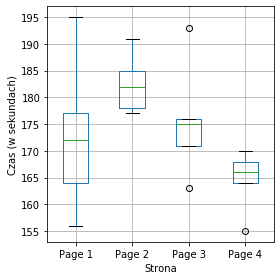

In [20]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Strona')
ax.set_ylabel('Czas (w sekundach)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [21]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


In [22]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Zaobserwowane średnie:', four_sessions.groupby('Page').mean().values.ravel())
print('Wariancja:', observed_variance)
# Przykład testu permutacyjnego
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Zaobserwowane średnie: [172.8 182.6 175.6 164.6]
Wariancja: 55.426666666666655
47.61333333333337


Pr(Prob) 0.079


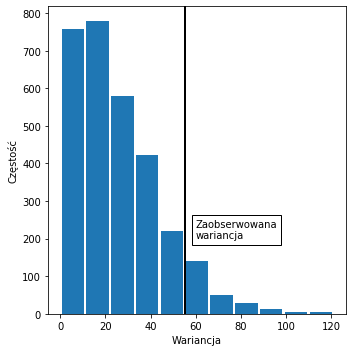

In [23]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Zaobserwowana\nwariancja', bbox={'facecolor':'white'})
ax.set_xlabel('Wariancja')
ax.set_ylabel('Częstość')

plt.tight_layout()
plt.show()

## Statystyka F
Możemy obliczyć tablicę ANOVA za pomocą pakietu statsmodel.

In [24]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [25]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'Statystyka F: {res.statistic / 2:.4f}')
print(f'p-wartość: {res.pvalue / 2:.4f}')

Statystyka F: 1.3699
p-wartość: 0.0388


### Dwukierunkowy algorytm ANOVA dostępny wyłącznie w pakiecie statsmodels
```
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
```

# Test chi-kwadrat
## Test chi-kwadrat: podejście randomizacyjne

In [28]:
# Tabela 3.4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [29]:
# Tabela 3.5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [30]:
# Metoda randomizacyjna
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # zwraca sumę kwadratów
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Zaobserwowana wartość chi2: {chi2observed:.4f}')
print(f'Randomizowana p-wartość: {resampled_p_value:.4f}')

Zaobserwowana wartość chi2: 1.6659
Randomizowana p-wartość: 0.4820


In [31]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Zaobserwowana wartość chi2: {chi2observed:.4f}')
print(f'p-wartość: {pvalue:.4f}')

Zaobserwowana wartość chi2: 1.6659
p-wartość: 0.4348


## Rozkład chi kwadrat

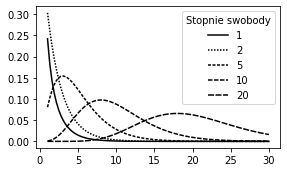

In [33]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='Stopnie swobody')

plt.tight_layout()
plt.show()

## Dokładny test Fishera
Pakiet Scipy zawiera jedynie implementację dokładnego testu Fishera dla macierzy 2x2. Dostępne jest repozytorium GitHub zawierające taką samą implementację, jak jest używana w wersji dla R. Do jej instalacji wymagany jest kompilator Fortrana. 
```
stats.fisher_exact(clicks)
```

In [25]:
# stats.fisher_exact(clicks.values)

### Oszustwo naukowe

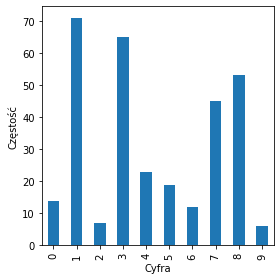

In [34]:
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Cyfra')
ax.set_ylabel('Częstość')

plt.tight_layout()
plt.show()

# Moc i rozmiar próby
Pakiet statsmodels zawiera wiele metod służących do obliczania mocy.

Zob. np. https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

In [35]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Rozmiar próby: %.3f' % result)

Rozmiar próby: 116602.393


In [36]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Rozmiar próby: %.3f' % result)

Rozmiar próby: 5488.408
